<h2>IMDB sentiment analysis</h2>
Deep Learning using Word Embedding for the IMDB sentiment analysis dataset.

Based on <a href="https://machinelearningmastery.com/predict-sentiment-movie-reviews-using-deep-learning/">How to Predict Sentiment From Movie Reviews Using Deep Learning (Text Classification)</a>.

<h3>Imports</h3>

In [1]:
import numpy as np
import pandas as pd
import time

import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Embedding, Dropout, GRU
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

print("TF version:", tf.__version__)

TF version: 2.2.0


<h3>Dataset statistics</h3>

In [2]:
# Dataset statistics
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = imdb.load_data()
x = np.concatenate((x_train_raw, x_test_raw), axis=0)

# Summarize number of words
print("Number of words:", len(np.unique(np.hstack(x))))

# Summarize review length
result = [len(xe) for xe in x]
print("Length of reviews: mean {0:.2f} words (std = {1:.5f})".format(np.mean(result), np.std(result)))

# See how many reviews are covered by max length
max_length = 500
cnt = 0
for xl in result:
    if xl <= max_length:
        cnt += 1
print("Percentage of reviews covered by max length: {0:.2f}%".format(cnt / len(result) * 100))

Number of words: 88585
Length of reviews: mean 234.76 words (std = 172.91149)
Percentage of reviews covered by max length: 91.93%


<h3>Load and pre-process data</h3>

In [3]:
# Load the dataset but only keep the top n words
top_words = 5000 # 5000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)

# Pad sentences to a specified length in words
max_words = 500
x_train = sequence.pad_sequences(x_train, maxlen=max_words)
x_test = sequence.pad_sequences(x_test, maxlen=max_words)

print("Training dataset:",x_train.shape)
print("Test dataset:",x_test.shape)

embedding_size = 64 # 32
print("Embeddings size:", embedding_size)

Training dataset: (25000, 500)
Test dataset: (25000, 500)
Embeddings size: 64


<h3>Function for training and evaluating a Keras network</h3>

In [4]:
def train_and_evaluate(model, no_epochs=5):
    filepath="weights_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max',save_weights_only=True)
    
    # Train model
    start = time.time()
    history = model.fit(x_train, y_train, epochs=no_epochs, batch_size=256, verbose=0, validation_data=(x_test,y_test), callbacks=[checkpoint])
    end = time.time()
    print("Training time: {0:.2f} sec".format(end-start))
    
    # Plot training history
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

    # Evaluate model on test data
    score = model.evaluate(x_test, y_test, verbose=0)
    # Print results
    print("\nTest Accuracy: {0:0.2f}%".format(score[1] * 100))

<h3>Linear classifier</h3>

Training time: 5.20 sec


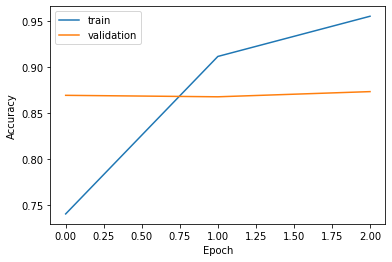


Test Accuracy: 87.34%


In [5]:
model = Sequential()
model.add(Embedding(input_dim=top_words, output_dim=embedding_size, input_length=max_words))
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.002), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=3)

<h3>Neural Network classifier</h3>

Training time: 15.25 sec


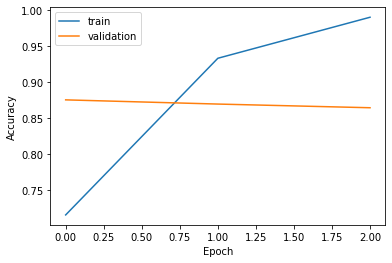


Test Accuracy: 86.44%


In [6]:
model = Sequential()
model.add(Embedding(input_dim=top_words, output_dim=embedding_size, input_length=max_words))
model.add(Flatten())
model.add(Dense(128, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.002), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=3)

<h3>ConvNet classifier</h3>

Training time: 54.19 sec


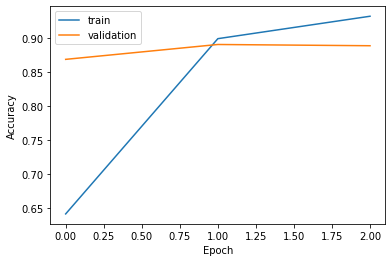


Test Accuracy: 88.85%


In [7]:
model = Sequential()
model.add(Embedding(input_dim=top_words, output_dim=embedding_size, input_length=max_words))
model.add(Conv1D(filters=64, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_uniform"))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=3)

<h3>Recurrent CNN+GRU classifier</h3>

See <a href="https://medium.com/@mrunal68/text-sentiments-classification-with-cnn-and-lstm-f92652bc29fd">Text Sentiments Classification with CNN and LSTM</a>.

Training time: 102.41 sec


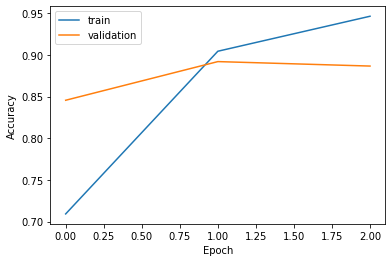


Test Accuracy: 88.67%


In [8]:
model = Sequential()
# Embedding layer
model.add(Embedding(input_dim=top_words, output_dim=embedding_size, input_length=max_words))
# ConvNet layer
model.add(Conv1D(filters=32, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_uniform"))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=5, padding="same", activation="relu", kernel_initializer="he_uniform"))
model.add(MaxPooling1D())
# Recurrent layer using GRU
model.add(GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# Fully connected layer
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.005, amsgrad=True), metrics=["accuracy"])

train_and_evaluate(model, no_epochs=3)

<h2>Compare with traditional ML methods</h2>

<h3>Imports</h3>

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn import svm

<h3>Convert to whitespace-separated string format</h3>

In [14]:
# Re-load data
(x_train_r, y_train), (x_test_r, y_test) = imdb.load_data(num_words=top_words)

# Convert
x_str_raw = []
for r in x_train_r:
    s = " ".join(map(str, r))
    x_str_raw.append(s)

for r in x_test_r:
    s = " ".join(map(str, r))
    x_str_raw.append(s)

<h3>Bag-of-words conversion</h3>

In [15]:
cvec = CountVectorizer()
cvec.fit(x_str_raw)
x_str = cvec.transform(x_str_raw)

tfid = TfidfTransformer().fit(x_str)
x_str = tfid.transform(x_str)

# Split into train and test sets
x_train_str = x_str[:25000]
x_test_str = x_str[25000:]

print(x_train_str.shape, x_test_str.shape)

(25000, 4990) (25000, 4990)


<h3>Function for training and evaluating a model</h3>

In [16]:
def train_and_evaluate_model(model):
    # Train model
    start = time.time()
    model.fit(x_train_str, y_train)
    end = time.time()
    print("Training time: {0:.2f} sec".format(end-start))
    
    # Evaluate model on test data
    y_pred = model.predict(x_test_str)
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("\nTest Accuracy: {0:0.2f}%".format(accuracy * 100))

<h3>Multinomial Naïve Bayes</h3>

In [17]:
train_and_evaluate_model(MultinomialNB())

Training time: 0.02 sec

Test Accuracy: 84.26%


<h3>SVM</h3>

In [18]:
train_and_evaluate_model(svm.LinearSVC(C=0.1))

Training time: 0.19 sec

Test Accuracy: 88.68%
